In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

2024-07-24 22:59:06.931962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 22:59:06.932072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 22:59:07.083685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
NUM_CLASSES = 6

In [3]:
dataset_dir = '/kaggle/input/faceexpression-dp'
image_dir = '/kaggle/input/faceexpression-dp/dataset'
csv_dir = '/kaggle/input/faceexpression-dp/data.csv'

In [4]:
data = pd.read_csv(csv_dir, index_col=0)

In [5]:
print(data.head())
print("-------------------------------------------")
print("Shape of the Data:",data.shape)

                                                path     label
0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4       Surprise/cropped_emotions.263616~12fffff.png  Surprise
-------------------------------------------
Shape of the Data: (15453, 2)


In [6]:
data['path'] = data['path'].apply(lambda x: os.path.join(image_dir,x))
print(data.head())

                                                path     label
0  /kaggle/input/faceexpression-dp/dataset/Surpri...  Surprise
1  /kaggle/input/faceexpression-dp/dataset/Surpri...  Surprise
2  /kaggle/input/faceexpression-dp/dataset/Surpri...  Surprise
3  /kaggle/input/faceexpression-dp/dataset/Surpri...  Surprise
4  /kaggle/input/faceexpression-dp/dataset/Surpri...  Surprise


In [7]:
data['label'].value_counts()

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

In [8]:
# Map string labels to numerical labels
label_mapping = {
    'Neutral': 0,
    'Sad': 1,
    'Happy': 2,
    'Angry': 3,
    'Surprise': 4,
    'Ahegao': 5
}

# Apply the mapping to the labels
data['label'] = data['label'].map(label_mapping)


In [9]:
data.head()

,path,label
0,/kaggle/input/faceexpression-dp/dataset/Surpri...,4
1,/kaggle/input/faceexpression-dp/dataset/Surpri...,4
2,/kaggle/input/faceexpression-dp/dataset/Surpri...,4
3,/kaggle/input/faceexpression-dp/dataset/Surpri...,4
4,/kaggle/input/faceexpression-dp/dataset/Surpri...,4


In [10]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['label'],random_state=42)


In [11]:
# Function to load and preprocess the images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

# Convert labels to one-hot encoding
def one_hot_encode(label):
    label = tf.one_hot(label, NUM_CLASSES)
    return label


In [12]:
# Create a tf.data.Dataset from the dataframe
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['path'].values, train_data['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data['path'].values, val_data['label'].values))

# Apply preprocessing
train_dataset = train_dataset.map(lambda path, label: (load_and_preprocess_image(path, label)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(lambda image, label: (image, one_hot_encode(label)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(lambda path, label: (load_and_preprocess_image(path, label)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(lambda image, label: (image, one_hot_encode(label)), num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [13]:
# Data augmentation for training dataset
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image, label


In [14]:
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [15]:
# Repeat, shuffle, batch, and prefetch
train_dataset = train_dataset.repeat().shuffle(buffer_size=len(train_data)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [16]:

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['label']),
    y=train_data['label']
)

class_weights_dict = dict(enumerate(class_weights))


In [17]:
# VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = len(train_data) // BATCH_SIZE
validation_steps = len(val_data) // BATCH_SIZE


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)
model_checkpoint = ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True,mode='min')

In [19]:
# Train the model
start_time = time.time()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)
end_time = time.time()

print("Training time in Minutes: ", round((end_time - start_time) / 60, 3))

model.load_weights('best_model.keras')
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset, steps=validation_steps)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/30
  2/772 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.1094 - loss: 3.1037    

I0000 00:00:1721862060.196386     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721862060.220749     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3606 - loss: 1.7206

W0000 00:00:1721862119.183755     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


772/772 ━━━━━━━━━━━━━━━━━━━━ 148s 97ms/step - accuracy: 0.3607 - loss: 1.7202 - val_accuracy: 0.4893 - val_loss: 1.3045
Epoch 2/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - accuracy: 0.5254 - loss: 1.1117 - val_accuracy: 0.5343 - val_loss: 1.2018
Epoch 3/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.5488 - loss: 1.0188 - val_accuracy: 0.5437 - val_loss: 1.1550
Epoch 4/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.6066 - loss: 0.8919 - val_accuracy: 0.5628 - val_loss: 1.1320
Epoch 5/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.6376 - loss: 0.8140 - val_accuracy: 0.5816 - val_loss: 1.1033
Epoch 6/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 78s 101ms/step - accuracy: 0.6425 - loss: 0.7800 - val_accuracy: 0.5742 - val_loss: 1.1064
Epoch 7/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 75s 97ms/step - accuracy: 0.6705 - loss: 0.7281 - val_accuracy: 0.5609 - val_loss: 1.1492
Epoch 8/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 75s 97ms/step - accuracy: 0.6987 - loss: 0.6626 - val_accur

In [20]:
# Evaluate the model
train_steps = len(train_data) // BATCH_SIZE
train_loss, train_accuracy = model.evaluate(train_dataset,steps=train_steps)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

772/772 ━━━━━━━━━━━━━━━━━━━━ 101s 78ms/step - accuracy: 0.7119 - loss: 0.7735
Train Loss: 0.7759852409362793
Train Accuracy: 0.7083063721656799


  3/193 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step

W0000 00:00:1721863027.352691     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step


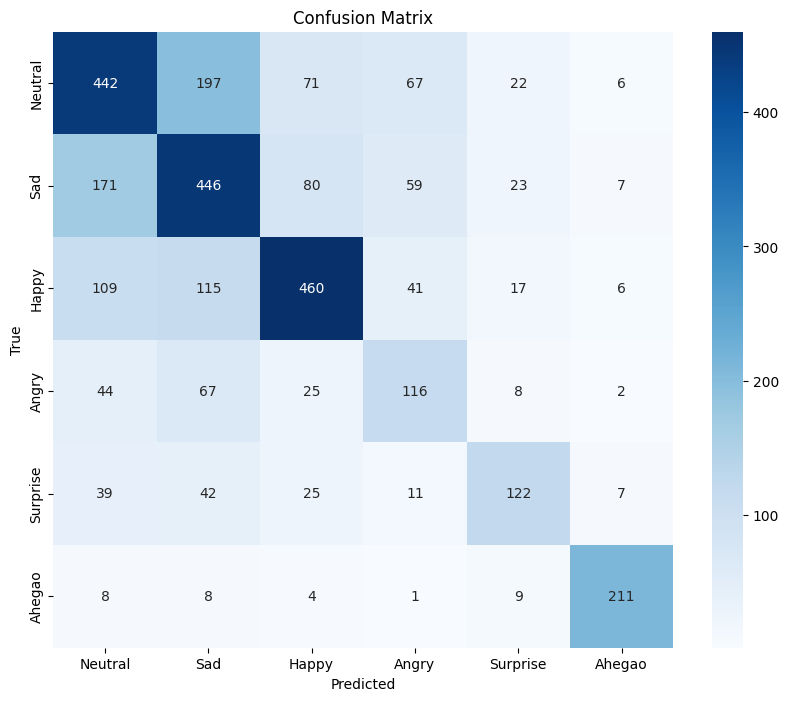

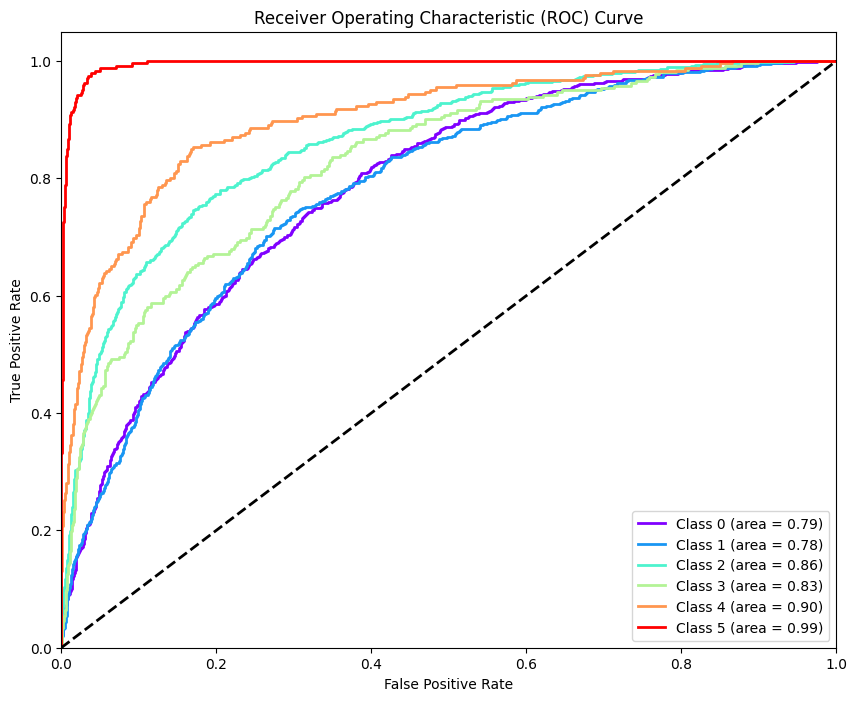

In [21]:


# Predict the validation data
y_pred = model.predict(val_dataset, steps=validation_steps)
y_true = val_data['label'][:len(y_pred)]

# Convert predictions to label indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [22]:
model.save('model.keras')

In [23]:
model1 = tf.keras.models.load_model('model.keras')

In [24]:
#unfreeze all layers of model2
for layer in model1.layers:
    layer.trainable = True

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)
model_checkpoint = ModelCheckpoint('new_best_model.keras',monitor='val_loss',save_best_only=True,mode='min')

In [26]:
model1.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
# Train the model
start_time = time.time()
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)
end_time = time.time()

print("Training time in Minutes: ", round((end_time - start_time) / 60, 3))

model.load_weights('new_best_model.keras')
# Evaluate the model
val_loss, val_accuracy = model1.evaluate(val_dataset, steps=validation_steps)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/30


W0000 00:00:1721863184.616253     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6890 - loss: 0.6946

W0000 00:00:1721863376.220656     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


772/772 ━━━━━━━━━━━━━━━━━━━━ 281s 269ms/step - accuracy: 0.6891 - loss: 0.6945 - val_accuracy: 0.6357 - val_loss: 0.9973
Epoch 2/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 207s 268ms/step - accuracy: 0.7271 - loss: 0.5771 - val_accuracy: 0.6684 - val_loss: 0.8990
Epoch 3/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 206s 267ms/step - accuracy: 0.7587 - loss: 0.5174 - val_accuracy: 0.6804 - val_loss: 0.8726
Epoch 4/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 206s 267ms/step - accuracy: 0.7820 - loss: 0.4662 - val_accuracy: 0.6966 - val_loss: 0.8275
Epoch 5/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 206s 267ms/step - accuracy: 0.7903 - loss: 0.4385 - val_accuracy: 0.7050 - val_loss: 0.7985
Epoch 6/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 205s 266ms/step - accuracy: 0.8033 - loss: 0.4144 - val_accuracy: 0.7111 - val_loss: 0.8113
Epoch 7/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 207s 268ms/step - accuracy: 0.8185 - loss: 0.3771 - val_accuracy: 0.7209 - val_loss: 0.7884
Epoch 8/30
772/772 ━━━━━━━━━━━━━━━━━━━━ 207s 268ms/step - accuracy: 0.8287 - loss: 0.33

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.7505 - loss: 0.7600
Validation Loss: 0.7534341812133789
Validation Accuracy: 0.7464378476142883


In [28]:
# Evaluate the model
train_steps = len(train_data) // BATCH_SIZE
train_loss, train_accuracy = model1.evaluate(train_dataset,steps=train_steps)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

772/772 ━━━━━━━━━━━━━━━━━━━━ 101s 78ms/step - accuracy: 0.9049 - loss: 0.2573
Train Loss: 0.263639897108078
Train Accuracy: 0.9023640155792236


  3/193 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step

W0000 00:00:1721866730.250970     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step


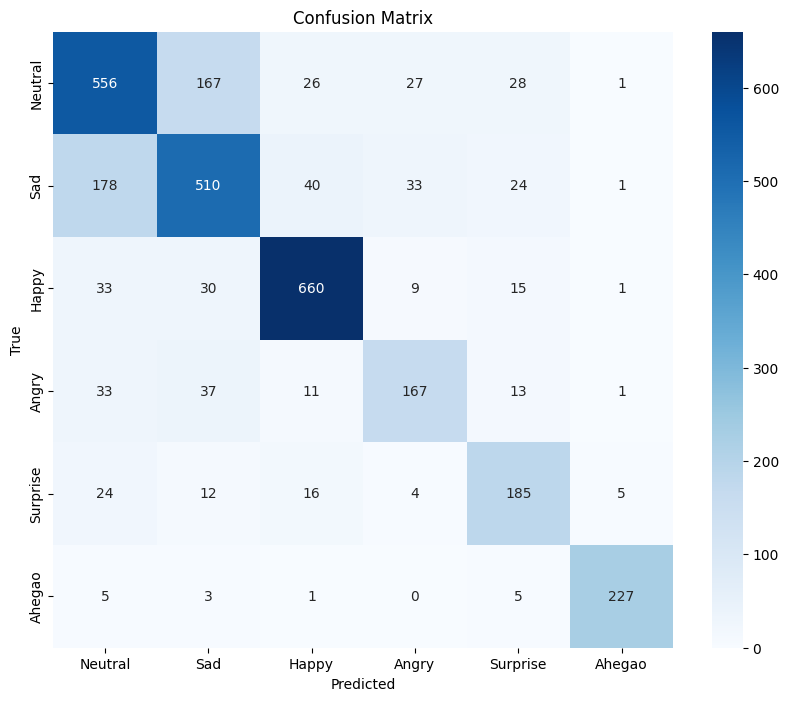

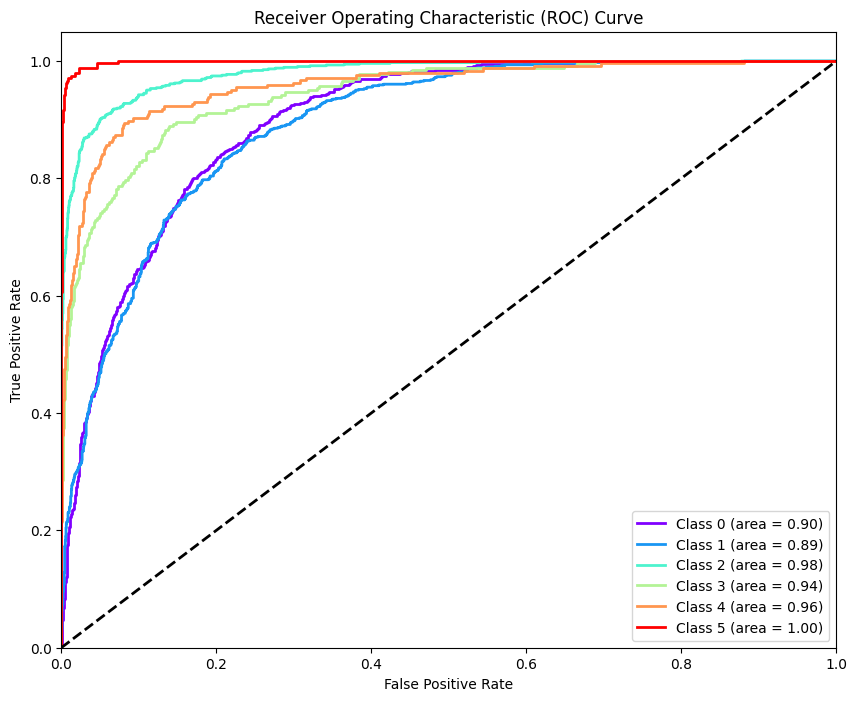

In [29]:


# Predict the validation data
y_pred = model1.predict(val_dataset, steps=validation_steps)
y_true = val_data['label'][:len(y_pred)]

# Convert predictions to label indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
model1.save('new_model.keras')